In [1]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.utils.data as data
from torch.autograd import Variable
from torchvision import datasets, transforms
import os
import csv
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, HTML
from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures

In [2]:
device = torch.device("cuda: 0") if torch.cuda.is_available() else torch.device("cpu")

In [3]:
TRAIN_DIR = "data/train.csv"
TEST_DIR = "data/test.csv"

In [4]:
MAKE_DATA = 1
PROCESS_DATA = 1
TRAIN_DATA = 1

In [5]:
table = pd.read_csv(TRAIN_DIR)
display(HTML(table.to_html()))

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.00,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.00,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.00,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.00,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.00,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.00,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.00,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.00,1,0,237736,30.0708,NaN,C


In [6]:
print(table.isnull().sum()) #Count empty cells (NaN)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [7]:
table = table.fillna(table.mean()) #Fill NaN cells with mean of the row

In [8]:
print(table.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [9]:
Y = table.iloc[:,1]
X = table.drop(["Survived","Name","Ticket","PassengerId","Embarked","Cabin"],axis = 1)
X.replace({'Sex':{'male' : 1, 'female': 0}},inplace = True)

In [10]:
NUM_PASSENGER = len(Y)
print("Number of passengers: {}".format(NUM_PASSENGER))

Number of passengers: 891


In [11]:
BATCH_SIZE = NUM_PASSENGER
TRAINING_SAMPLES = 800
VAL_SAMPLES = 91

In [12]:
X = np.array(X).reshape(X.shape[0], -1).astype(np.float32) #Convert into numpy array
Y = np.array(Y).reshape(-1,1)

poly = PolynomialFeatures(2)
X_poly = poly.fit_transform(X)
print(X.shape)
print(X_poly.shape)

In [13]:
NUM_PARAMETER = len(X[0])
print(NUM_PARAMETER)

6


In [14]:
one_hot = torch.LongTensor(np.eye(2))

In [15]:
class LinearRegression(nn.Module):
    def __init__(self, inp):
        super(LinearRegression, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(inp,10),
            nn.Linear(10,1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.main(x)
        

In [16]:
def training_step(model, optimizer, error, trainloader):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for (target, label) in trainloader:
        model.zero_grad()
        target = Variable(target).view(-1,NUM_PARAMETER).to(device)
        label = Variable(label).view(-1,1).to(device)
        #one_hot_label = one_hot[label]
        #one_hot_label = Variable(one_hot_label).to(device)
        
        outputs = model(target)
        
        prediction = 1 if outputs.data>0.5 else 0 #torch.max(outputs.data, 1)[1]

        loss = error(outputs, label.float())
        
        loss.backward()
        optimizer.step()
        train_loss += loss.data
        total += len(target)
        correct += (prediction == label).sum()
    acc = correct*1.0/total
    return train_loss, acc

In [17]:
def evaluating_step(model, optimizer, error, valloader):
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for (target, label) in valloader:
            target = Variable(target).view(-1,NUM_PARAMETER).to(device)
            label = Variable(label).view(-1,1).to(device)
            #one_hot_label = one_hot[label]
            #one_hot_label = Variable(one_hot_label).to(device)
            outputs = model(target)
            prediction = 1 if outputs.data>0.5 else 0 #torch.max(outputs.data, 1)[1]
            loss = error(outputs, label.float())
            val_loss += loss.data
            total += len(target)
            correct += (prediction == label).sum()
        acc = correct*1.0/total
    return val_loss, acc

In [18]:
def plot(train_loss_list, train_acc_list, val_loss_list, val_acc_list, EPOCHS):
    fig = plt.figure(figsize=(20,5))
    fig.add_subplot(1,2,1)
    plt.plot(range(EPOCHS),train_loss_list, label = "Training Loss")
    plt.plot(range(EPOCHS),val_loss_list, color = "orange", label = "Validation Loss")
    plt.legend()
    fig.add_subplot(1,2,2)
    plt.plot(range(EPOCHS),train_acc_list, label = "Training Accuracy")
    plt.plot(range(EPOCHS),val_acc_list, color = "orange", label = "Validation Accuracy")
    plt.legend()
    plt.show()

In [19]:
def train(EPOCHS, model, optimizer, error, trainloader, valloader):
    train_loss_list = []
    val_loss_list = []
    train_acc_list = []
    val_acc_list = []
    for epoch in range(EPOCHS):
        train_loss, train_acc = training_step(model,optimizer, error, trainloader)
        val_loss, val_acc = evaluating_step(model,optimizer, error, valloader)
        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)
        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)
        print("Epoch: ({}/{}), Train loss: {:3f}, Train Acc: {:3f}, Val loss: {:3f}, Val Acc: {:3f}".format(epoch+1,EPOCHS, train_loss,
                                                                                                train_acc, val_loss, val_acc))
    return model, train_loss_list, train_acc_list, val_loss_list, val_acc_list

Start training at fold: 1...
Epoch: (1/30), Train loss: 564.498657, Train Acc: 0.672909, Val loss: 60.474415, Val Acc: 0.611111
Epoch: (2/30), Train loss: 481.166443, Train Acc: 0.709114, Val loss: 57.144966, Val Acc: 0.633333
Epoch: (3/30), Train loss: 452.205872, Train Acc: 0.751561, Val loss: 55.526279, Val Acc: 0.666667
Epoch: (4/30), Train loss: 435.627777, Train Acc: 0.756554, Val loss: 54.577953, Val Acc: 0.677778
Epoch: (5/30), Train loss: 424.407623, Train Acc: 0.756554, Val loss: 53.894722, Val Acc: 0.677778
Epoch: (6/30), Train loss: 416.629639, Train Acc: 0.766542, Val loss: 53.316803, Val Acc: 0.688889
Epoch: (7/30), Train loss: 411.012939, Train Acc: 0.777778, Val loss: 52.849991, Val Acc: 0.700000
Epoch: (8/30), Train loss: 407.180908, Train Acc: 0.782772, Val loss: 52.498955, Val Acc: 0.711111
Epoch: (9/30), Train loss: 404.971527, Train Acc: 0.782772, Val loss: 52.290958, Val Acc: 0.711111
Epoch: (10/30), Train loss: 403.211823, Train Acc: 0.784020, Val loss: 52.194065

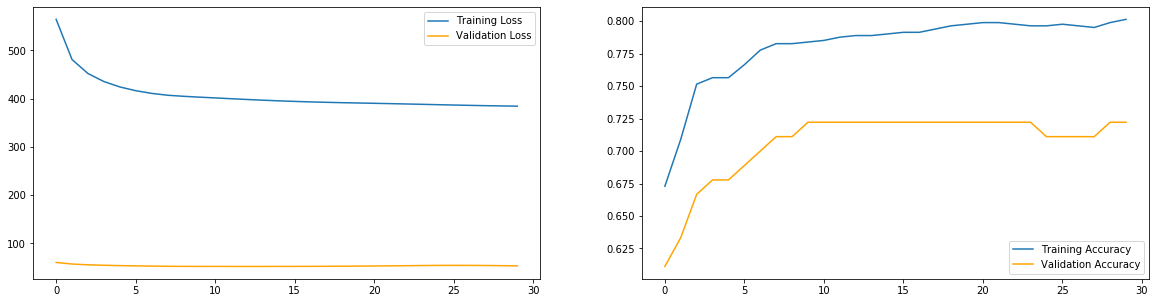

Start training at fold: 2...
Epoch: (1/30), Train loss: 572.536926, Train Acc: 0.658354, Val loss: 51.632866, Val Acc: 0.730337
Epoch: (2/30), Train loss: 484.099884, Train Acc: 0.710723, Val loss: 48.315884, Val Acc: 0.752809
Epoch: (3/30), Train loss: 455.604706, Train Acc: 0.746883, Val loss: 46.580647, Val Acc: 0.764045
Epoch: (4/30), Train loss: 438.924591, Train Acc: 0.759352, Val loss: 45.799919, Val Acc: 0.786517
Epoch: (5/30), Train loss: 428.652100, Train Acc: 0.773067, Val loss: 45.335716, Val Acc: 0.808989
Epoch: (6/30), Train loss: 423.325500, Train Acc: 0.773067, Val loss: 44.995956, Val Acc: 0.820225
Epoch: (7/30), Train loss: 420.560913, Train Acc: 0.776808, Val loss: 44.730789, Val Acc: 0.820225
Epoch: (8/30), Train loss: 418.640717, Train Acc: 0.780549, Val loss: 44.485729, Val Acc: 0.820225
Epoch: (9/30), Train loss: 416.576843, Train Acc: 0.784289, Val loss: 44.217636, Val Acc: 0.820225
Epoch: (10/30), Train loss: 414.310913, Train Acc: 0.785536, Val loss: 43.947311

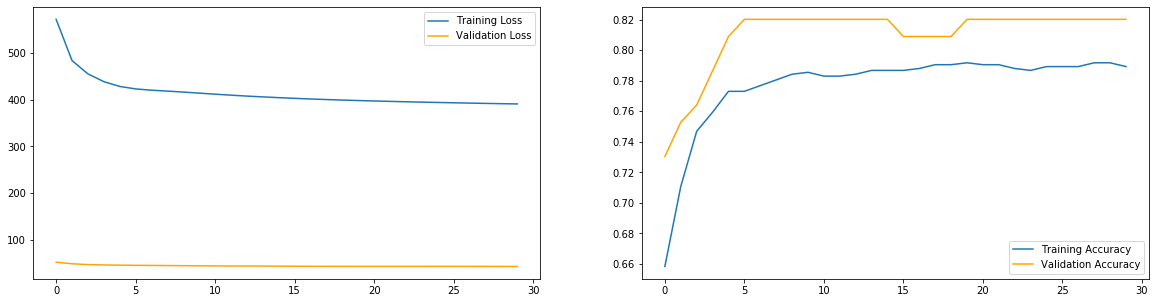

Start training at fold: 3...
Epoch: (1/30), Train loss: 562.677246, Train Acc: 0.655860, Val loss: 44.962593, Val Acc: 0.696629
Epoch: (2/30), Train loss: 496.619873, Train Acc: 0.704489, Val loss: 43.919483, Val Acc: 0.719101
Epoch: (3/30), Train loss: 460.109406, Train Acc: 0.748130, Val loss: 43.353863, Val Acc: 0.730337
Epoch: (4/30), Train loss: 440.414520, Train Acc: 0.763092, Val loss: 42.965023, Val Acc: 0.764045
Epoch: (5/30), Train loss: 428.362457, Train Acc: 0.760599, Val loss: 42.722458, Val Acc: 0.775281
Epoch: (6/30), Train loss: 420.095490, Train Acc: 0.770574, Val loss: 42.641190, Val Acc: 0.764045
Epoch: (7/30), Train loss: 414.438171, Train Acc: 0.774314, Val loss: 42.685131, Val Acc: 0.786517
Epoch: (8/30), Train loss: 410.792633, Train Acc: 0.778055, Val loss: 42.809471, Val Acc: 0.786517
Epoch: (9/30), Train loss: 408.261993, Train Acc: 0.784289, Val loss: 42.983730, Val Acc: 0.786517
Epoch: (10/30), Train loss: 406.199005, Train Acc: 0.783042, Val loss: 43.164349

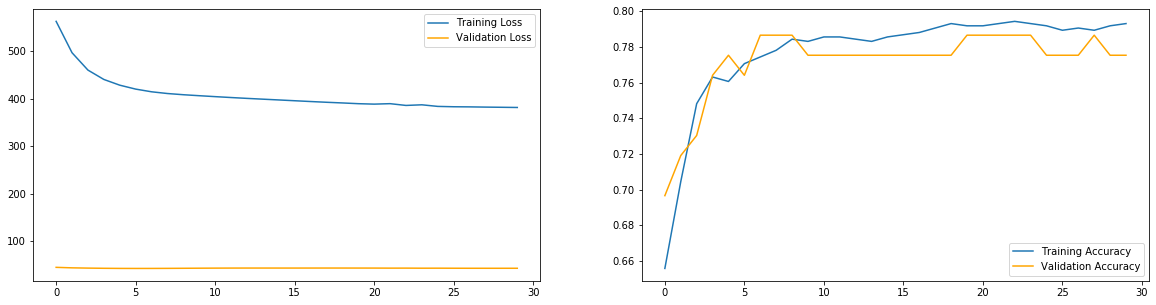

Start training at fold: 4...
Epoch: (1/30), Train loss: 527.093262, Train Acc: 0.669576, Val loss: 52.888363, Val Acc: 0.696629
Epoch: (2/30), Train loss: 486.505615, Train Acc: 0.706983, Val loss: 50.928673, Val Acc: 0.696629
Epoch: (3/30), Train loss: 458.459045, Train Acc: 0.728180, Val loss: 49.701889, Val Acc: 0.719101
Epoch: (4/30), Train loss: 444.023407, Train Acc: 0.748130, Val loss: 49.078777, Val Acc: 0.741573
Epoch: (5/30), Train loss: 434.724731, Train Acc: 0.751870, Val loss: 48.916504, Val Acc: 0.764045
Epoch: (6/30), Train loss: 428.495911, Train Acc: 0.759352, Val loss: 48.704697, Val Acc: 0.764045
Epoch: (7/30), Train loss: 421.391632, Train Acc: 0.763092, Val loss: 48.743839, Val Acc: 0.764045
Epoch: (8/30), Train loss: 416.681976, Train Acc: 0.769327, Val loss: 48.626095, Val Acc: 0.786517
Epoch: (9/30), Train loss: 413.011993, Train Acc: 0.774314, Val loss: 48.811630, Val Acc: 0.786517
Epoch: (10/30), Train loss: 409.996246, Train Acc: 0.778055, Val loss: 48.413746

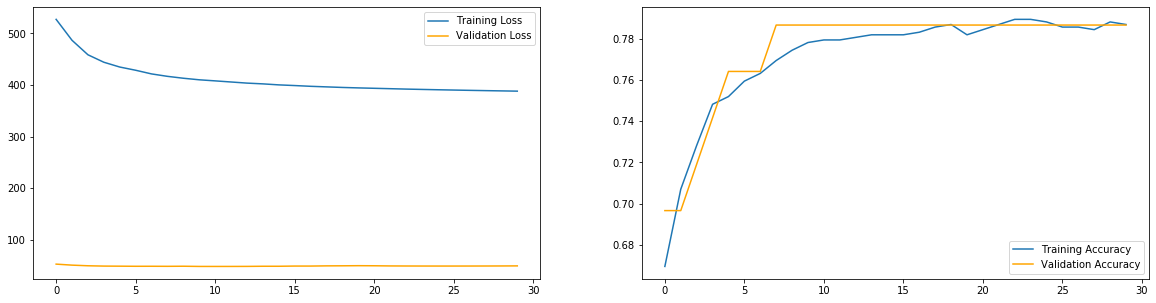

Start training at fold: 5...
Epoch: (1/30), Train loss: 549.901978, Train Acc: 0.673317, Val loss: 65.001884, Val Acc: 0.674157
Epoch: (2/30), Train loss: 498.406342, Train Acc: 0.724439, Val loss: 60.637566, Val Acc: 0.696629
Epoch: (3/30), Train loss: 464.211426, Train Acc: 0.751870, Val loss: 58.898293, Val Acc: 0.696629
Epoch: (4/30), Train loss: 443.043335, Train Acc: 0.768080, Val loss: 58.438946, Val Acc: 0.719101
Epoch: (5/30), Train loss: 432.061493, Train Acc: 0.775561, Val loss: 58.242542, Val Acc: 0.719101
Epoch: (6/30), Train loss: 424.383148, Train Acc: 0.779302, Val loss: 58.035854, Val Acc: 0.730337
Epoch: (7/30), Train loss: 418.435333, Train Acc: 0.783042, Val loss: 57.857113, Val Acc: 0.741573
Epoch: (8/30), Train loss: 413.866089, Train Acc: 0.783042, Val loss: 57.682167, Val Acc: 0.730337
Epoch: (9/30), Train loss: 410.521210, Train Acc: 0.783042, Val loss: 57.482204, Val Acc: 0.730337
Epoch: (10/30), Train loss: 408.377808, Train Acc: 0.786783, Val loss: 57.255245

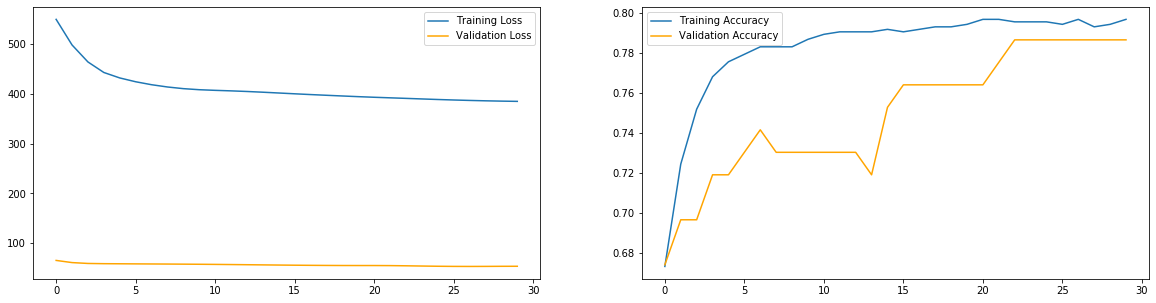

Start training at fold: 6...
Epoch: (1/30), Train loss: 531.036194, Train Acc: 0.664589, Val loss: 52.445663, Val Acc: 0.730337
Epoch: (2/30), Train loss: 469.035889, Train Acc: 0.725686, Val loss: 51.066593, Val Acc: 0.775281
Epoch: (3/30), Train loss: 446.117035, Train Acc: 0.753117, Val loss: 50.667072, Val Acc: 0.786517
Epoch: (4/30), Train loss: 432.932068, Train Acc: 0.755611, Val loss: 50.664684, Val Acc: 0.786517
Epoch: (5/30), Train loss: 424.057281, Train Acc: 0.761845, Val loss: 50.832695, Val Acc: 0.808989
Epoch: (6/30), Train loss: 417.896851, Train Acc: 0.769327, Val loss: 51.010448, Val Acc: 0.808989
Epoch: (7/30), Train loss: 413.401337, Train Acc: 0.770574, Val loss: 51.116783, Val Acc: 0.808989
Epoch: (8/30), Train loss: 409.835480, Train Acc: 0.775561, Val loss: 51.090519, Val Acc: 0.797753
Epoch: (9/30), Train loss: 406.922974, Train Acc: 0.784289, Val loss: 50.889214, Val Acc: 0.786517
Epoch: (10/30), Train loss: 404.556519, Train Acc: 0.785536, Val loss: 50.586823

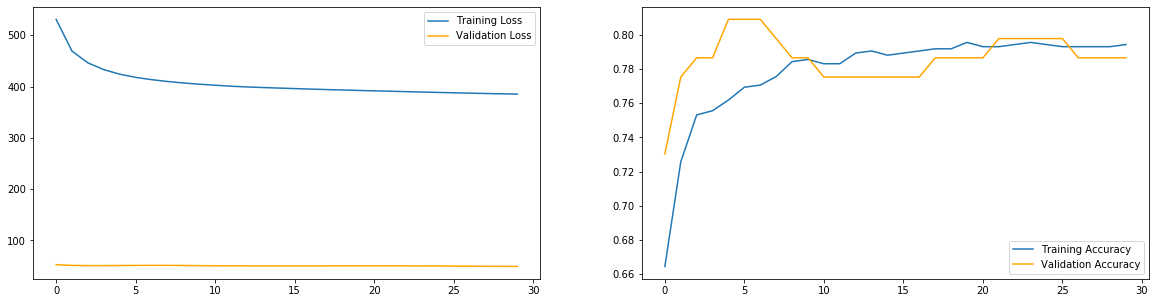

Start training at fold: 7...
Epoch: (1/30), Train loss: 606.503357, Train Acc: 0.658354, Val loss: 52.374470, Val Acc: 0.752809
Epoch: (2/30), Train loss: 495.859650, Train Acc: 0.714464, Val loss: 51.900970, Val Acc: 0.741573
Epoch: (3/30), Train loss: 466.019287, Train Acc: 0.745636, Val loss: 51.974514, Val Acc: 0.730337
Epoch: (4/30), Train loss: 447.523987, Train Acc: 0.753117, Val loss: 51.973656, Val Acc: 0.730337
Epoch: (5/30), Train loss: 434.396027, Train Acc: 0.766833, Val loss: 51.975140, Val Acc: 0.764045
Epoch: (6/30), Train loss: 425.206055, Train Acc: 0.768080, Val loss: 52.138512, Val Acc: 0.764045
Epoch: (7/30), Train loss: 418.266083, Train Acc: 0.775561, Val loss: 52.192616, Val Acc: 0.775281
Epoch: (8/30), Train loss: 413.773956, Train Acc: 0.781796, Val loss: 52.283573, Val Acc: 0.775281
Epoch: (9/30), Train loss: 410.780670, Train Acc: 0.788030, Val loss: 52.366188, Val Acc: 0.775281
Epoch: (10/30), Train loss: 408.782837, Train Acc: 0.793018, Val loss: 52.382614

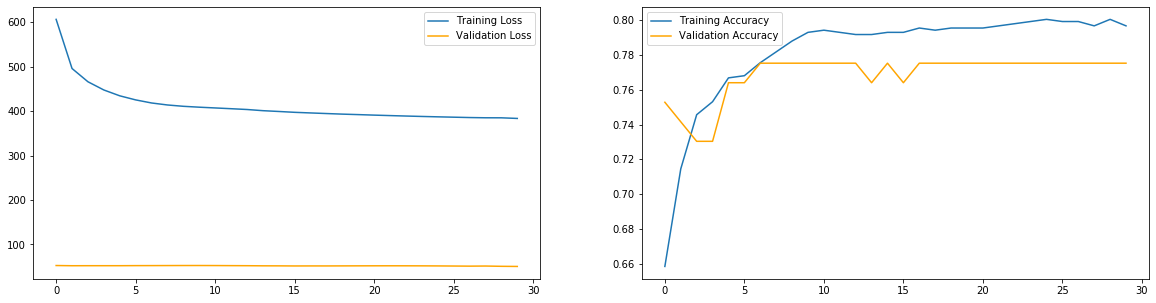

Start training at fold: 8...
Epoch: (1/30), Train loss: 576.306396, Train Acc: 0.657107, Val loss: 45.652004, Val Acc: 0.719101
Epoch: (2/30), Train loss: 512.084778, Train Acc: 0.723192, Val loss: 45.442707, Val Acc: 0.719101
Epoch: (3/30), Train loss: 472.941223, Train Acc: 0.745636, Val loss: 45.416832, Val Acc: 0.741573
Epoch: (4/30), Train loss: 453.501740, Train Acc: 0.764339, Val loss: 45.237595, Val Acc: 0.730337
Epoch: (5/30), Train loss: 438.541595, Train Acc: 0.771820, Val loss: 45.077511, Val Acc: 0.741573
Epoch: (6/30), Train loss: 427.674988, Train Acc: 0.778055, Val loss: 44.986874, Val Acc: 0.741573
Epoch: (7/30), Train loss: 420.492554, Train Acc: 0.783042, Val loss: 44.930298, Val Acc: 0.741573
Epoch: (8/30), Train loss: 415.916046, Train Acc: 0.783042, Val loss: 44.910316, Val Acc: 0.741573
Epoch: (9/30), Train loss: 412.474640, Train Acc: 0.779302, Val loss: 44.958630, Val Acc: 0.741573
Epoch: (10/30), Train loss: 409.453827, Train Acc: 0.786783, Val loss: 45.099277

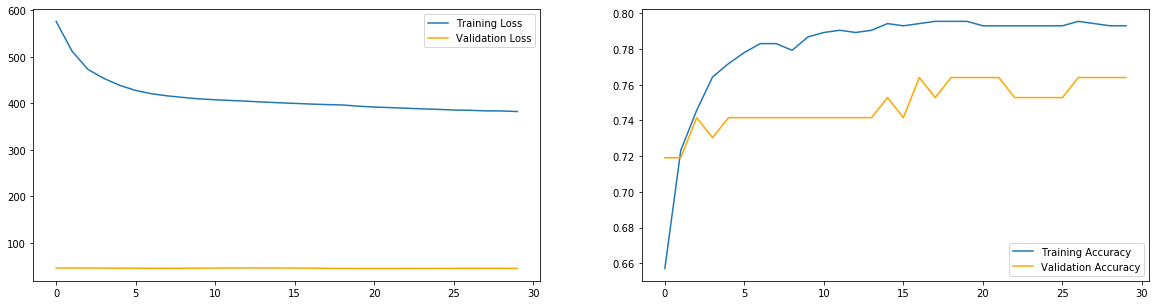

Start training at fold: 9...
Epoch: (1/30), Train loss: 573.993103, Train Acc: 0.652120, Val loss: 39.453136, Val Acc: 0.775281
Epoch: (2/30), Train loss: 496.365051, Train Acc: 0.711970, Val loss: 36.549717, Val Acc: 0.808989
Epoch: (3/30), Train loss: 465.896667, Train Acc: 0.741895, Val loss: 35.234238, Val Acc: 0.820225
Epoch: (4/30), Train loss: 448.821594, Train Acc: 0.755611, Val loss: 34.598862, Val Acc: 0.831461
Epoch: (5/30), Train loss: 437.250244, Train Acc: 0.760599, Val loss: 34.198662, Val Acc: 0.842697
Epoch: (6/30), Train loss: 429.862335, Train Acc: 0.764339, Val loss: 33.857998, Val Acc: 0.842697
Epoch: (7/30), Train loss: 425.945801, Train Acc: 0.769327, Val loss: 33.531796, Val Acc: 0.842697
Epoch: (8/30), Train loss: 423.055511, Train Acc: 0.770574, Val loss: 33.212727, Val Acc: 0.842697
Epoch: (9/30), Train loss: 420.559631, Train Acc: 0.773067, Val loss: 32.965347, Val Acc: 0.842697
Epoch: (10/30), Train loss: 418.145996, Train Acc: 0.779302, Val loss: 32.734489

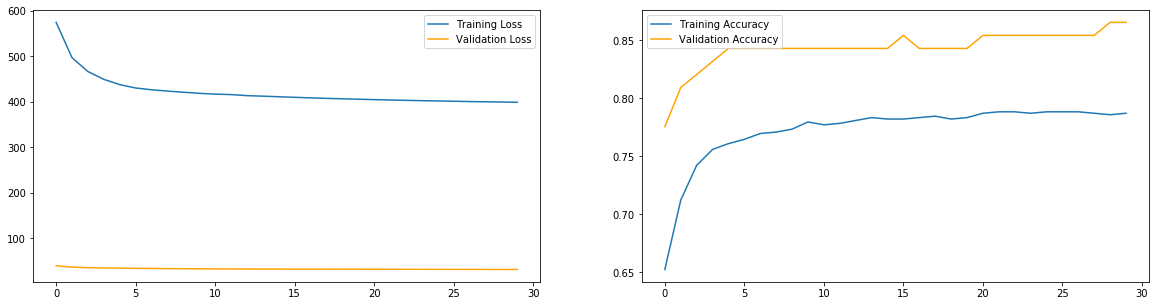

Start training at fold: 10...
Epoch: (1/30), Train loss: 596.059387, Train Acc: 0.648379, Val loss: 48.804859, Val Acc: 0.696629
Epoch: (2/30), Train loss: 507.818420, Train Acc: 0.705736, Val loss: 44.592361, Val Acc: 0.741573
Epoch: (3/30), Train loss: 478.874268, Train Acc: 0.733167, Val loss: 43.242527, Val Acc: 0.752809
Epoch: (4/30), Train loss: 459.520325, Train Acc: 0.743142, Val loss: 42.461914, Val Acc: 0.775281
Epoch: (5/30), Train loss: 445.793030, Train Acc: 0.754364, Val loss: 41.869186, Val Acc: 0.797753
Epoch: (6/30), Train loss: 435.346710, Train Acc: 0.759352, Val loss: 41.416031, Val Acc: 0.797753
Epoch: (7/30), Train loss: 427.156921, Train Acc: 0.764339, Val loss: 41.069099, Val Acc: 0.786517
Epoch: (8/30), Train loss: 421.183258, Train Acc: 0.770574, Val loss: 40.815281, Val Acc: 0.786517
Epoch: (9/30), Train loss: 415.785248, Train Acc: 0.775561, Val loss: 40.672783, Val Acc: 0.797753
Epoch: (10/30), Train loss: 412.417358, Train Acc: 0.778055, Val loss: 40.54034

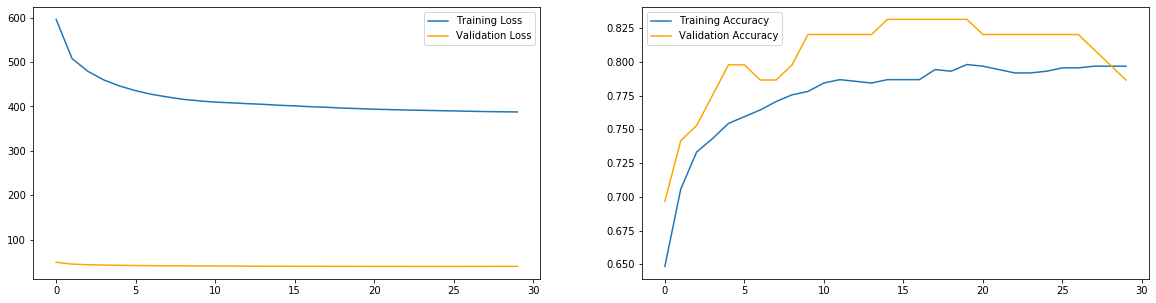

Best fold: 9


In [20]:
if TRAIN_DATA:
    EPOCHS = 30
    best_val_acc = 0
    best_fold = 0
    kf = KFold(n_splits=10)
    for fold, (train_id, val_id) in enumerate(kf.split(X)):
        X_train , X_val = X[train_id], X[val_id]
        y_train, y_val = Y[train_id], Y[val_id]
        
        trainset = data.TensorDataset(torch.from_numpy(X_train), torch.LongTensor(torch.from_numpy(y_train)))
        valset = data.TensorDataset(torch.from_numpy(X_val), torch.LongTensor(torch.from_numpy(y_val)))
        
        trainloader = data.DataLoader(trainset, num_workers= 4, batch_size=1)
        valloader = data.DataLoader(valset, num_workers= 4, batch_size=1)
        
        model = LinearRegression(NUM_PARAMETER).to(device)
        error = nn.BCELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr= 0.005, weight_decay=1e-4)
        print("Start training at fold: {}...".format(fold+1))
        model, train_loss_list, train_acc_list, val_loss_list, val_acc_list = train(EPOCHS,model,optimizer,error,trainloader,valloader)
        print("Fold {} completed! Plotting...".format(fold+1))
        plot(train_loss_list, train_acc_list, val_loss_list, val_acc_list, EPOCHS)
        if val_acc_list[-1] > best_val_acc:
            best_val_acc = val_acc_list[-1]
            torch.save(model.state_dict(), "model/model1.pth")
            best_fold = fold+1
    
    print("Best fold: {}".format(best_fold))

In [54]:
def predict(model, X):
    model.eval()
    prediction = []
    with torch.no_grad():
        X = Variable(torch.from_numpy(X)).view(-1,NUM_PARAMETER).to(device)
        outputs = model(X)
        prediction = [1 if i > 0.5 else 0 for i in outputs.data]
    return prediction

In [55]:
table_test = pd.read_csv(TEST_DIR)
#display(HTML(table_test.to_html()))

In [62]:
table = table.fillna(table.mean()) #Fill NaN cells with mean of the row
X_label = table["PassengerId"]
X_test = table.drop(["Name","Ticket","PassengerId","Embarked","Cabin"],axis = 1)
X_test.replace({'Sex':{'male' : 1, 'female': 0}},inplace = True)
X_test = np.array(X_test).astype(np.float32)
X_label = np.array(X_label)

In [63]:
from tqdm import tqdm

In [64]:
result = predict(model,X_test)
with open("predict.csv", "w", newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["PassengerID", "Survived"])
    for (i,j) in tqdm(zip(X_label,result)):
        writer.writerow([i,j])

418it [00:00, 418929.29it/s]
